# Test: CSA T1 Formula Comparison for η=0

This notebook compares two CSA T1 formulas for the η=0 case using simulated data.

This test generates a trajectory with cone diffusion (η=0 CSA), calculates J(ω),
then compares T1 from:
1. **Universal formula**: R1 = f₀² × J(ω₀) × 10⁻¹²  (works for any η)
2. **Analytical formula**: R1 = (1/3) × (f₀ × Δσ)² × J(ω₀)  (only for η=0)

The key insight is that these formulas expect **different types of input**.

## Setup: Import Libraries

In [1]:
import numpy as np
import sys
import os

# Add parent directory to path if needed
sys.path.insert(0, os.path.dirname(os.getcwd()))

from nmr_calculator.config import NMRConfig
from nmr_calculator.xyz_generator import TrajectoryGenerator
from nmr_calculator.euler_converter import EulerConverter
from nmr_calculator.spherical_harmonics import SphericalHarmonicsCalculator
from nmr_calculator.autocorrelation import AutocorrelationCalculator
from nmr_calculator.spectral_density import SpectralDensityCalculator
from nmr_calculator.nmr_parameters import NMRParametersCalculator

## Parameters

In [2]:
# Physical parameters
S2 = 0.85
tau_c = 5e-9  # 5 ns
delta_sigma = 160.0  # ppm
B0 = 14.1  # Tesla
nucleus = '13C'

print("Parameters:")
print(f"  S² = {S2}")
print(f"  τc = {tau_c*1e9:.1f} ns")
print(f"  Δσ = {delta_sigma} ppm")
print(f"  B₀ = {B0} T")
print(f"  Nucleus: {nucleus}")
print(f"  η = 0 (uniaxial)")

Parameters:
  S² = 0.85
  τc = 5.0 ns
  Δσ = 160.0 ppm
  B₀ = 14.1 T
  Nucleus: 13C
  η = 0 (uniaxial)


## Step 1: Generate Trajectory and Calculate J(ω)

Generate a diffusion-in-cone trajectory with η=0 CSA and calculate the spectral density.

In [3]:
# Configure simulation
config = NMRConfig(
    trajectory_type='vector_on_cone',  # Changed from 'simulate_vector_on_cone'
    S2=S2,
    tau_c=tau_c,
    dt=10e-12,
    num_steps=2000,
    B0=B0,
    nucleus=nucleus,
    interaction_type='CSA',
    delta_sigma=delta_sigma,
    eta=0.0,
    calculate_T1=True,
    verbose=True
)

In [ ]:
# Generate trajectory
print("Generating trajectory...")
gen = TrajectoryGenerator(config)
rotations, _ = gen.generate()

# plot sample trajactories
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Generating trajectory...

MODULE 1: Simulating Vector on Cone Surface
  S² = 0.8500
  τc = 5.00 ns
  dt = 10.00 ps
  Steps = 2000
  Cone axis = [0 0 1]
  Cone angle θ = 18.43°

  ✓ Generated 2000 unit vectors
  ✓ All vectors at fixed angle θ = 18.43° from axis
  ✓ Converted 2000 vectors to rotation matrices


In [6]:
# Convert to Euler angles
print("\nConverting to Euler angles...")
converter = EulerConverter(config)
euler_angles = converter.convert(rotations=rotations)


Converting to Euler angles...

MODULE 2: Converting to Euler Angles
  Local axis definition: CO_CA
  Shape: (2000, 3)
  Convention: ZYZ (alpha, beta, gamma)
  Angular ranges:
    α: -136.9° to 34.4°
    β: 18.4° to 18.4°
    γ: -34.4° to 136.9°



Calculating spherical harmonics...
Using NumPy-optimized Wigner d-matrix calculation

MODULE 3: Calculating Spherical Harmonics
  Interaction type: CSA
  CSA Parameters:
    δ_iso: 0.00 ppm
    Δδ (anisotropy): 160.00 ppm
    η (asymmetry): 0.000
  Converted to tensor components:
    δ_xx: -80.00 ppm
    δ_yy: -80.00 ppm
    δ_zz: 160.00 ppm
  Using NumPy-optimized calculation

  Y₂ₘ statistics (full Wigner D-matrix calculation):
    Y₂^-2: mean=7.630, std=3.576
    Y₂^-1: mean=47.304, std=21.930
    Y₂^+0: mean=166.565, std=0.000
    Y₂^+1: mean=47.304, std=21.930
    Y₂^+2: mean=7.630, std=3.576
  ✓ Calculated Y₂ₘ for 2000 time steps
  Shape: (2000, 5)


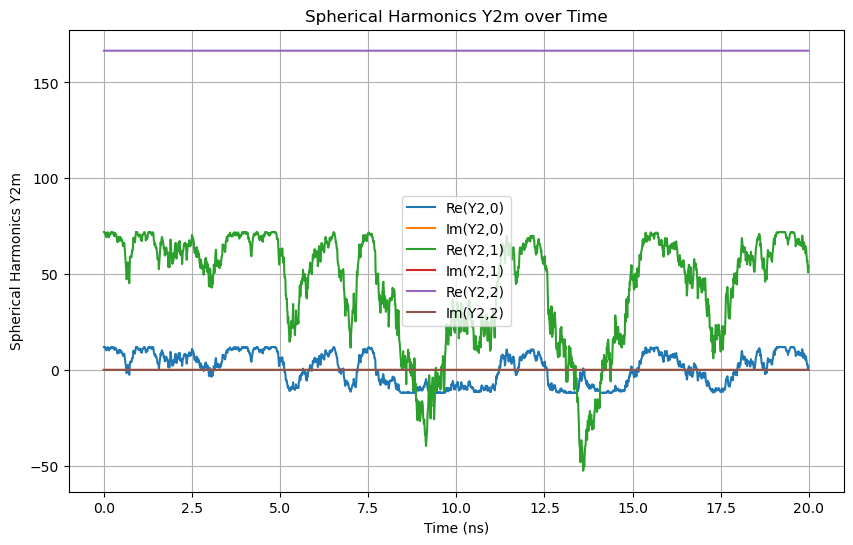

In [7]:
# Calculate spherical harmonics
print("\nCalculating spherical harmonics...")
sh_calc = SphericalHarmonicsCalculator(config)
Y2m = sh_calc.calculate(euler_angles)

# plot Y2m series
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
time = np.arange(config.num_steps) * config.dt * 1e9  # time    
plt.plot(time, Y2m[:, 0].real, label='Re(Y2,0)')
plt.plot(time, Y2m[:, 0].imag, label='Im(Y2,0)')
plt.plot(time, Y2m[:, 1].real, label='Re(Y2,1)')
plt.plot(time, Y2m[:, 1].imag, label='Im(Y2,1)')
plt.plot(time, Y2m[:, 2].real, label='Re(Y2,2)')
plt.plot(time, Y2m[:, 2].imag, label='Im(Y2,2)')
plt.xlabel('Time (ns)')
plt.ylabel('Spherical Harmonics Y2m')
plt.title('Spherical Harmonics Y2m over Time')
plt.legend()
plt.grid()
plt.show()


Calculating autocorrelation...

  Computing full correlation matrix (5×5) using direct method...
  ✓ Computed 25 correlation functions

MODULE 4: Calculating Autocorrelation Function
  Method: Direct calculation (matches t1_anisotropy_analysis.py)
  Total time steps: 2000
  Maximum lag: 1000
  Lag step: 1
  Time step dt: 1.00e-11 s
  ✓ Calculated ACF with 1000 lag points
  Time range: 0 to 9.99e-09 s
  ACF[0] (normalized): 1.000
  ACF decay at τ_c: 0.921
  ✓ Calculated ACF with 1000 lag points
  Time range: 0 to 9.99e-09 s
  ACF[0] (normalized): 1.000
  ACF decay at τ_c: 0.921


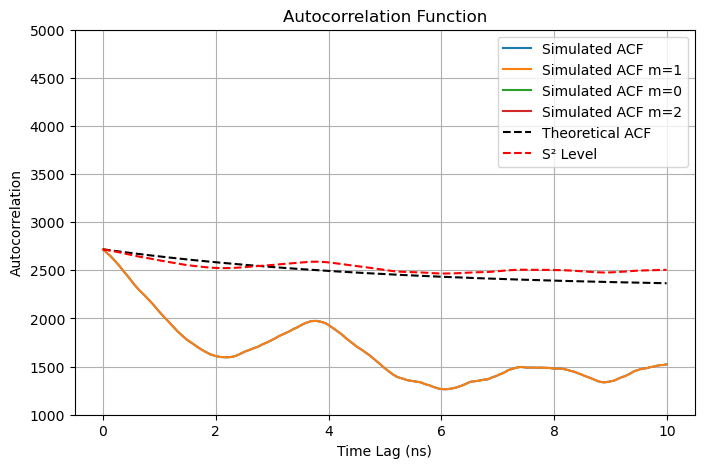

In [25]:
# Calculate autocorrelation function
print("\nCalculating autocorrelation...")
config.max_lag=1000
acf_calc = AutocorrelationCalculator(config)
corr_matrix = acf_calc.compute_correlation_matrix(Y2m)
acf, lags = acf_calc.calculate(Y2m)
time_lags = np.arange(config.max_lag) * config.dt * 1e9
# plot autocorrelation function
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(time_lags, corr_matrix[(-1, -1)], label='Simulated ACF')
plt.plot(time_lags, corr_matrix[(1, 1)], label='Simulated ACF m=1')
plt.plot(time_lags, corr_matrix[(0, 0)], label='Simulated ACF m=0')
plt.plot(time_lags, corr_matrix[(2, 2)], label='Simulated ACF m=2')
plt.plot(time_lags, (S2 + (1 - S2) * np.exp(-time_lags * 1e-9 / tau_c))*corr_matrix[(-1, -1)][0], 'k--', label='Theoretical ACF')
plt.plot(time_lags, acf*corr_matrix[(-1, -1)][0], 'r--', label='S² Level')
plt.xlabel('Time Lag (ns)')
plt.ylim([1000, 5000])
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.legend()
plt.grid()
plt.show()


Calculating spectral density...

MODULE 6: Calculating Spectral Density
  Method: FFT with cosine transform
  ACF length: 1000
  Time range: 0 to 9.99e-09 s
  Zero-fill factor: 2×
  DC offset (avg of last 100 points): 1.45e+03
  After zero-fill: 2000 points
  Applied moving average smoothing (window=5)
  ✓ Calculated spectral density
  Frequency points: 1001
  Frequency range: 0.00e+00 to 3.14e+11 rad/s
  J(0): 1.79e-06

  Frequency markers:
    1H: ω=6.00e+08 rad/s, J(ω)=2.02e-06
    13C: ω=1.51e+08 rad/s, J(ω)=1.79e-06
    15N: ω=-6.09e+07 rad/s, J(ω)=1.79e-06
    31P: ω=2.43e+08 rad/s, J(ω)=1.82e-06


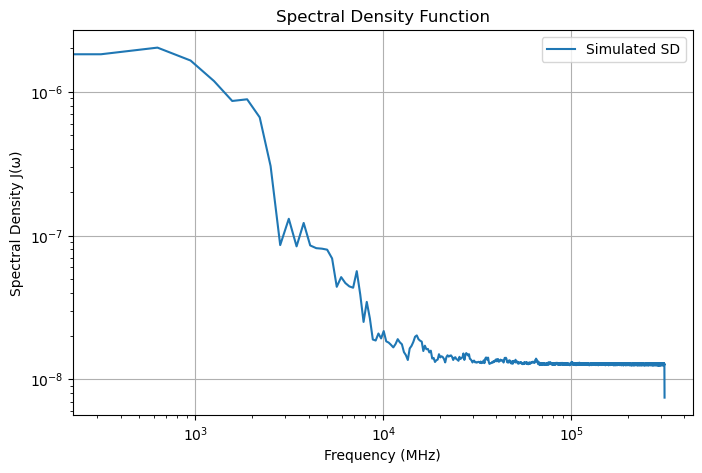

In [17]:
# Calculate spectral density
print("\nCalculating spectral density...")
config.zero_fill_factor=2
config.smoothing_window=5
sd_calc = SpectralDensityCalculator(config)
J_sim, freq_sim = sd_calc.calculate(corr_matrix[(-1, -1)], time_lags*1e-9)

# plot spectral density
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.semilogy(freq_sim*1e-6, J_sim, label='Simulated SD')
plt.xscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Spectral Density J(ω)')
plt.title('Spectral Density Function')
plt.legend()
plt.grid()
plt.show()

In [18]:
# Extract J(ω₀)
omega_0 = config.get_omega0()
idx_omega0 = np.argmin(np.abs(freq_sim - omega_0))
J_omega0 = J_sim[idx_omega0]

print(f"\nSimulated J(ω₀) = {J_omega0:.3e} s")
print(f"ω₀ = {omega_0:.3e} rad/s ({omega_0/(2*np.pi)*1e-6:.2f} MHz)")


Simulated J(ω₀) = 1.644e-06 s
ω₀ = 9.484e+08 rad/s (150.94 MHz)


## Step 2: Calculate T1 using Universal Formula

**Universal formula**: R1 = f₀² × J(ω₀) × 10⁻¹² (f₀ in Hz)

This formula works for any η and expects J(ω) from correlation functions in ppm² units.

In [19]:
calc_universal = NMRParametersCalculator(config)
T1_universal, _ = calc_universal.calculate(J_sim, freq_sim)

print(f"\nT1 (universal formula): {T1_universal:.3f} s ({T1_universal*1000:.1f} ms)")
print(f"R1 (universal): {calc_universal.R1_csa:.3e} s⁻¹")


MODULE 7: Calculating NMR Relaxation Parameters
  Nucleus: 13C
  B₀: 14.1 T
  Interaction type: CSA

  Spectral density values:
    J_0: 1.79e-06
    J_omega: 1.64e-06

  CSA T1 calculation (universal formula, any η):
    ω₀: 9.48e+08 rad/s (1.51e+08 Hz)
    J(ω₀): 1.64e-06 s
    R1_CSA: 0.037 s⁻¹
    Note: Correlation function must be in ppm² units
  ✓ T1 = 26.693 s (26692.6 ms)

T1 (universal formula): 26.693 s (26692.6 ms)
R1 (universal): 3.746e-02 s⁻¹


## Step 3: Calculate T1 using Analytical Formula (η=0 only)

**Analytical formula**: R1 = (1/3) × (f₀ × Δσ × 10⁻⁶)² × J(ω₀)

This formula only works for η=0 and expects J(ω) from NORMALIZED correlation functions.

In [ ]:
# fit tau_c and S2 value


In [ ]:
# Manually calculate using analytical formula
larmor_freq_Hz = omega_0 / (2 * np.pi)
delta_sigma_abs_Hz = delta_sigma * 1e-6 * larmor_freq_Hz  # Convert ppm to Hz

# Analytical: R1 = (1/3) × (f₀ × Δσ × 10⁻⁶)² × J(ω₀)
R1_analytical = (1.0/3.0) * (delta_sigma_abs_Hz)**2 * J_omega0
T1_analytical = 1.0 / R1_analytical

print(f"\nAnalytical calculation:")
print(f"  f₀ = {larmor_freq_Hz:.3e} Hz ({larmor_freq_Hz*1e-6:.2f} MHz)")
print(f"  Δσ = {delta_sigma} ppm = {delta_sigma_abs_Hz:.3e} Hz")
print(f"  J(ω₀) = {J_omega0:.3e} s")
print(f"  R1 = (1/3) × ({delta_sigma_abs_Hz:.2e})² × {J_omega0:.2e}")
print(f"  R1 = {R1_analytical:.3e} s⁻¹")
print(f"\nT1 (analytical formula): {T1_analytical:.3f} s ({T1_analytical*1000:.1f} ms)")

## Step 4: Comparison

Compare the two formulas and understand their relationship.

In [ ]:
# Universal formula details
R1_universal = calc_universal.R1_csa

print("="*70)
print("COMPARISON")
print("="*70)

print(f"\nUniversal Formula: R1 = f₀² × J(ω₀) × 10⁻¹²")
print(f"  f₀ = {larmor_freq_Hz:.2e} Hz")
print(f"  R1 = ({larmor_freq_Hz:.2e})² × {J_omega0:.2e} × 10⁻¹²")
print(f"  R1 = {R1_universal:.3e} s⁻¹")
print(f"  T1 = {T1_universal:.3f} s ({T1_universal*1000:.1f} ms)")

print(f"\nAnalytical Formula: R1 = (1/3) × (f₀×Δσ×10⁻⁶)² × J(ω₀)")
print(f"  Δσ = {delta_sigma} ppm = {delta_sigma_abs_Hz:.2e} Hz")
print(f"  R1 = (1/3) × ({delta_sigma_abs_Hz:.2e})² × {J_omega0:.2e}")
print(f"  R1 = {R1_analytical:.3e} s⁻¹")
print(f"  T1 = {T1_analytical:.3f} s ({T1_analytical*1000:.1f} ms)")

In [ ]:
# Calculate ratios
ratio_R1 = R1_universal / R1_analytical
ratio_T1 = T1_universal / T1_analytical

print(f"\n{'='*70}")
print("FORMULA RATIO")
print(f"{'='*70}")
print(f"\nR1 ratio (universal/analytical): {ratio_R1:.6f}")
print(f"T1 ratio (universal/analytical): {ratio_T1:.6f}")

# Expected theoretical ratio
# Universal: R1 = f₀² × J × 10⁻¹²
# Analytical: R1 = (1/3) × (f₀ × Δσ_ppm × 10⁻⁶)² × J
#           = (1/3) × f₀² × Δσ_ppm² × 10⁻¹² × J
# Ratio = 1 / [(1/3) × Δσ_ppm²] = 3 / Δσ_ppm²

expected_ratio = 3.0 / (delta_sigma**2)
print(f"\nExpected ratio from theory: {expected_ratio:.6e}")
print(f"Actual ratio: {ratio_R1:.6e}")
print(f"\nThese don't match because the formulas expect DIFFERENT J(ω) inputs!")

## Conclusion

The two formulas are **NOT directly equivalent** - they apply to different types of input!

In [ ]:
print("="*70)
print("CONCLUSION")
print("="*70)
print(f"\nThe two formulas are NOT directly equivalent!")
print(f"\n1. Universal formula: R1 = f₀² × J(ω₀) × 10⁻¹²")
print(f"   - Assumes J(ω) from correlation in ppm² units")
print(f"   - CSA magnitude already in correlation function")
print(f"   - Works for ANY η value")
print(f"   - T1 = {T1_universal*1000:.1f} ms")

print(f"\n2. Analytical formula: R1 = (1/3) × (f₀×Δσ×10⁻⁶)² × J(ω₀)")
print(f"   - Assumes J(ω) from NORMALIZED correlation")
print(f"   - CSA magnitude (Δσ) applied separately in formula")
print(f"   - Only valid for η = 0")
print(f"   - T1 = {T1_analytical*1000:.1f} ms")

print(f"\nFor η=0 with our simulated data:")
print(f"  T1 ratio: {ratio_T1:.2f}×")
print(f"\nTo use analytical formula correctly, need to normalize ACF first!")
print(f"\n{'='*70}")

## Summary

Key takeaways:

- **Universal formula** is used when the correlation function already contains CSA in ppm units (from trajectory with spherical harmonics)
- **Analytical formula** is used with normalized correlation functions (e.g., from Lipari-Szabo theory)
- For trajectory-based calculations with any η, always use the **universal formula**
- The analytical formula is mainly for theoretical calculations with η=0